# Analyzing Data

In this code the goal is to create a figure that contains three different axes. The requirements for the figures are as following:
1. Create a Heatmap
2. Choose any axes type
3. Choose any axes type except barchart, scatterplot oder line diagram

The list is equal to the list of the original task. In the elaboration this order is restructered to get a more logical order to link the individual axes to each other. 

*FYI:* All files were written within a .py file-format. In This case it's different because of the figures. It's more efficient to show them right away within an .ipynb file, than always safe them and look afterwards.

## Connecting to DB

At first an connection to the dabase is established, to get access to the data. The output of the Code is an SQL-Query, that contains the databasename (first element) und -status (second element). It's just to proof, that the connection was sucessful.
</br></br>
*CAUTION:* The following Code was written for an locally hosted SQL-Server with Windows Authentification. For more information consider reading 'Projects\3_Task\categorized.py', there you can find wider specification of the used database.

In [30]:
''' The Code was copy/pasted 3_Task\categorized.py . The code is not in a class because of the following reasons :
    - every code has to be delivered on a specific date and after that date the code will not be changed anymore
    - therefore the code is not refactored
    - in a real business case the code would be refactored and put into a class to be reuseable
'''

import pyodbc as odbc

DRIVER = input(r'Insert Driver name')           # input driver name -> use because of different driver names
print(f"you choose: {DRIVER} as your driver")   # print driver name for confirmation
                 
SERVER = input(r'Insert Server name')           # input server name -> use because of different server names
print(f"you choose: {SERVER} as your server")   # print server name for confirmation

DB = input(r'Insert Database name')             # input database name -> use because of different database names
print(f"you choose: {DB} as your database")     # print database name for confirmation


# Build Connection
connect_string = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DB};Trusted_Connection=yes;'   # build connection string
conn = odbc.connect(connect_string)                                                         # connect to database
cursor = conn.cursor()                                                                      # create cursor object

cursor.execute(f"SELECT DB_NAME() AS DatabaseName, CONVERT(varchar(255),DATABASEPROPERTYEX('master', 'Status')) AS DBStatus")   # small query to get the server status, no further use, just for showing the connection works
x = cursor.fetchall()                                                                                                           # fetch query result -> returns a list of tuples                           
print('Server Status: ',x)                                                                                                      # print query result

you choose: SQL Server 	 as your driver
you choose: CUBRIM\SQLExpress 	 as your server
you choose: mueller 	 as your database
Server Status:  [('mueller', 'ONLINE')]


## Data-Convertion Methods

As it may have come through, the data is stored within a SQL Server Database. A 'cursor' is used to get access to this data, which is than safe in a variable. The variable is of the type list and each element within this list is an tupel. Each Tupel contains the data of one row.

As describe, after executing the SQL-query, fetching the data and saving the result within a variable, the structure looks like this (refer to diagrams):

```python
[(data1, data2,...),(data1, data2,...),(data1, data2,...)]
```

 The problem here is, that the data can't easily be used in this kind of format. So it need a convertion or reshape. In this case the data was converted to match a pandas dataframe, which is further used as data for the axes.
 In some case like the Box plot (refer to diagrams) it is also possible to load the results of an SQL-Query directly into a Dataframe. Sometimes that wasn't possible because of further manipulation, but both versions are represented within the code.

In [ ]:
def getMeanByQuartal (data: list)-> list:
    '''used to shape data for specific year and quartal'''
    
    '''Variables declartation for mean calculation for each quartal'''
    dataOUT = []

    meanByQ1 = 0
    countDataQ1 = 0

    meanByQ2 = 0
    countDataQ2 = 0

    meanByQ3 = 0
    countDataQ3 = 0

    meanByQ4 = 0
    countDataQ4 = 0

    '''loop through data and sum up data for each quartal'''
    for i in range (0, len(data)):
        if data[i][3] == '1. quarter':                      # IF-statements to check for quartal
            countDataQ1 += 3                                # count data for mean calculation -> 3 data points per quartal (approve, approve Democrat, approve Republican)
            meanByQ1 += data[i][0]+data[i][1]+data[i][2]    # sum up data for mean calculation

        elif data[i][3] == '2. quarter':                    # IF-statements to check for quartal -> further explanation see above
            countDataQ2 += 3
            meanByQ2 += data[i][0]+data[i][1]+data[i][2]

        elif data[i][3] == '3. quarter':                    # IF-statements to check for quartal -> further explanation see above
            countDataQ3 += 3
            meanByQ3 += data[i][0]+data[i][1]+data[i][2]

        elif data[i][3] == '4. quarter':                    # IF-statements to check for quartal -> further explanation see above
            countDataQ4 += 3
            meanByQ4 += data[i][0]+data[i][1]+data[i][2]

    '''calculate mean for each quartal and append to dataOUT'''
        # IF-statements to avoid division by zero 
        # true -> append 0 to dataOUT
        # false -> calculate mean and append to dataOUT

    if countDataQ1 == 0:
        dataOUT.append(0)
    else:
        meanByQ1 = meanByQ1 / countDataQ1
        dataOUT.append(meanByQ1)

    if countDataQ2 == 0:
        dataOUT.append(0)
    else:
        meanByQ2 = meanByQ2 / countDataQ2
        dataOUT.append(meanByQ2)

    if countDataQ3 == 0:
        dataOUT.append(0)
    else:
        meanByQ3 = meanByQ3 / countDataQ3
        dataOUT.append(meanByQ3)

    if countDataQ4 == 0:
        dataOUT.append(0)
    else:
        meanByQ4 = meanByQ4 / countDataQ4
        dataOUT.append(meanByQ4)

    return dataOUT 


def convertListTupleToList(listIN: list)-> list:
    '''used convert list of tuples into one-dimensional list'''

    listOUT = []    # declare list for output

    for i in range (0, len(listIN)):    # loop through list of tuples
        listOUT.append(listIN[i][0])    # append first element of tuple to listOUT -> CAUTION: listIN has to be structured, that the 0th element of the tuple is the data that is needed

    return listOUT                      # return listOUT

def dataYearQuartal (data: list)-> list:
    '''used to get the data for a specific year and quartal'''
    
    dataOUT = [0,0,0,0]

    for i in range (0, len(data)):
        if data[i][0] == '1. quarter':
            dataOUT[0] = data[i][1]

        elif data[i][0] == '2. quarter':
            dataOUT[1] = data[i][1]

        elif data[i][0] == '3. quarter':
            dataOUT[2] = data[i][1]

        elif data[i][0] == '4. quarter':
            dataOUT[3] = data[i][1]

    return dataOUT

## Diagrams

The diagrams contain the three figures that were described in the beginning. Due to the reason, that the data at the core are survey results, the figures are build around this topic

***Transparency notice:***
<br><br>
In the following figures don't regard every datatuple that is represented in the database. This is due to the reason, that the data has to be plainly and no ambiguities (Especially relevant for the heatmap and barchart (in this case)). That is not given in one dataset, where the start and end year aren't the same and two additional datasets, where the start and end quarter don't match. The expense were to extensive to fit the data nicely into the figures without manipulating it. For that reason the decision was made to remove the data out of the figures completly because there are still enough datasets left to still create meaningful statements. 'Where'-statements where used within the SQL-Queries to perform this action.

### Box plot
The Boxplot was choosen to represent the first figure to get and categorized overview over all survery results categorized by approve, disapprove, unsure, approve (Democrats), approve (Republicans).

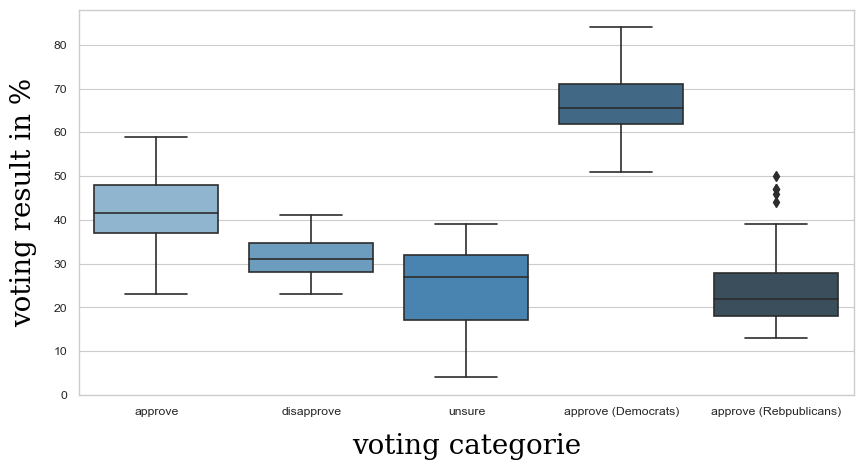

In [87]:
# Using the pandas 'read_sql' function to directly load the data from an SQL query into a dataframe
# Because of the not using SQl-Alchemy, pandas gives a user warning, but it works fine and the warning can be ignored
# That's the reason why the warning is filtered out by warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

'''SQL Query and Data Preparation'''

df_data_without = pd.read_sql(f"SELECT approve, disapprove, unsure, approveDemocrats, approveRepublicans FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal", con=conn)  # load data from SQL query directly into dataframe
df_data_without.rename(columns={'approveDemocrats': 'approve (Democrats)', 'approveRepublicans': 'approve (Rebpublicans)' }, inplace=True)    # rename columns for better understanding

'''Plotting'''
fig, ax = plt.subplots(figsize=(10,5))                                                              # create figure and axis object                 
ax = sns.boxplot(data=df_data_without, palette="Blues_d")                                                   # create boxplot
ax.set_xlabel('voting categorie', fontsize=20, fontfamily='serif', color='black', labelpad=12)      # set x-label
ax.set_ylabel('voting result in %', fontsize=20, fontfamily='serif', color='black', labelpad=12)    # set y-label

fig.savefig('images\\BOXPLOT_approval_rate_by_voting_categories', dpi=300, bbox_inches='tight')     # save figure

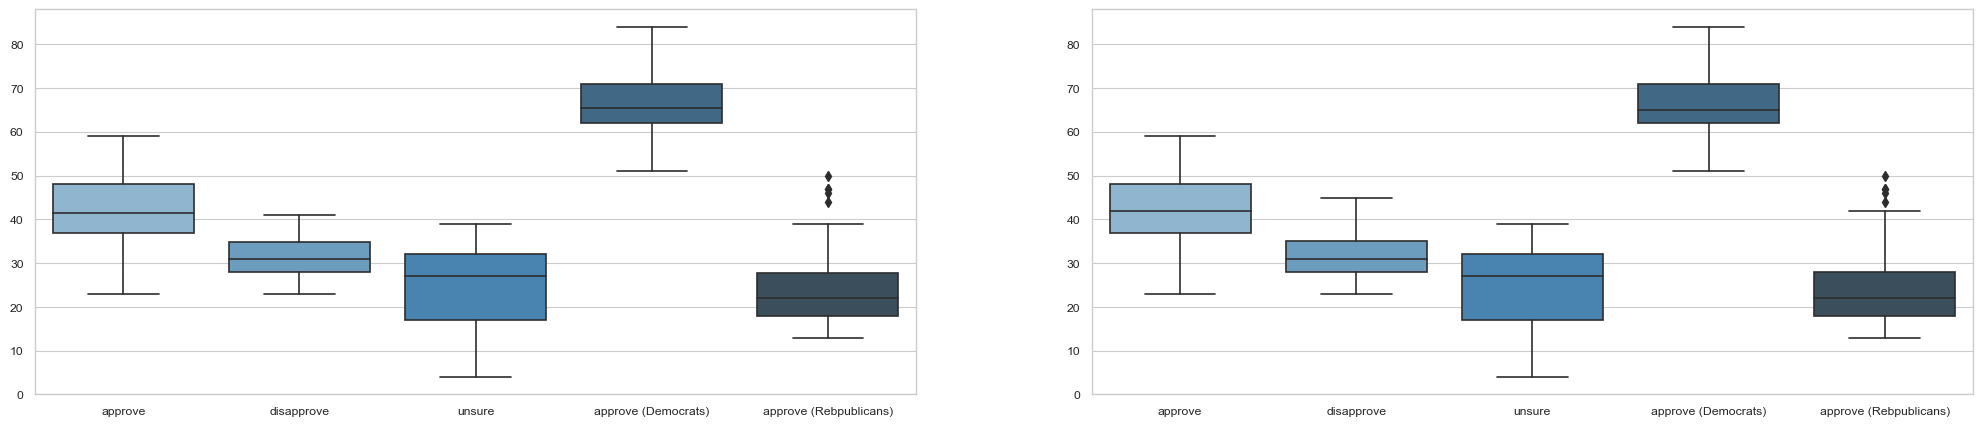

In [88]:
'''SQL Query and Data Preparation for second boxplot with the described exceptions of the data'''
    # just to show the difference between the two boxplots for transparency reasons-> the second boxplot is not used in the final report
    
df_data_with = pd.read_sql(f"SELECT approve, disapprove, unsure, approveDemocrats, approveRepublicans FROM all_fact_dim", con=conn) # load data from SQL query directly into dataframe
df_data_with.rename(columns={'approveDemocrats': 'approve (Democrats)', 'approveRepublicans': 'approve (Rebpublicans)' }, inplace=True)    # rename columns for better understanding

'''Plotting'''
fig, axes = plt.subplots(1, 2, figsize=(25,5))                              # create figure and axis object
box1 = sns.boxplot(ax=axes[0], data=df_data_without, palette="Blues_d")     # create boxplot for Democrats and Republicans
box2 = sns.boxplot(ax=axes[1], data=df_data_with, palette="Blues_d")        # create boxplot for approve, disapprove and unsure

### Heatmap

After getting an overview with the box plot. It's now interestin to have a look at, in which period of time the most approve (in mean) were given. It's common sense, that external factors influence our decisions and here are also some trends noticeable.

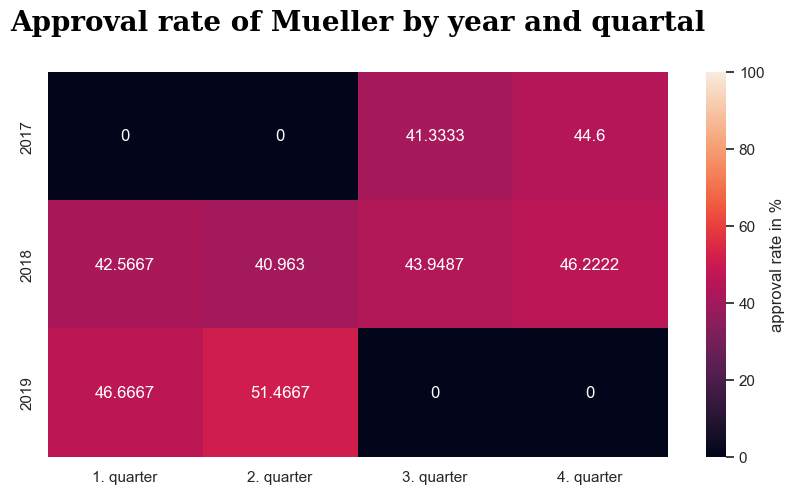

In [7]:
'''SQL Querys'''

### SQL-Querys to get the labels for the dataframe ###

# Select all years (distinct) where a survey was made
cursor.execute(f"SELECT DISTINCT YEAR(startDate) FROM fact_survey WHERE YEAR(startDate) = YEAR(endDate)")
result_years = cursor.fetchall()
labels_year = convertLisTupleToList(result_years)

#  Select all quarter types
cursor.execute(f"SELECT categorie FROM dim_categorieDate")
result_quarters = cursor.fetchall()
labels_quarter = convertListTupleToList(result_quarters)

### SQL-Querys to get the data for the dataframe ###

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2017")  # Select all approval rates from 2017 where Start and End Date are equal and the quarter is equal
data_2017 = cursor.fetchall()                                                                                                                                                                           # fetch query result -> returns a list of tuples

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2018")  # Select all approval rates from 2018 where Start and End Date are equal and the quarter is equal
data_2018 = cursor.fetchall()                                                                                                                                                                           # see above

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2019") # Select all approval rates from 2019 where Start and End Date are equal and the quarter is equal
data_2019 = cursor.fetchall()                                                                                                                                                                          # see above

'''Data Preparation'''

data_2017 = getMeanByQuartal(data_2017)     # get mean for each quartal
data_2018 = getMeanByQuartal(data_2018)     # see above
data_2019 = getMeanByQuartal(data_2019)     # see above

heat_array = (data_2017, data_2018, data_2019)                                  # create array for heatmap -> CAUTION: the order of the data is important for the heatmap
df_heat = pd.DataFrame(heat_array, index=labels_year, columns=labels_quarter)   # create dataframe for heatmap

'''Plotting'''
fig, ax = plt.subplots(figsize=(10,5))                                                                                                                  # create figure and axis                                     
ax = sns.heatmap(df_heat, annot=True, fmt="g", vmin=0, vmax=100, annot_kws={"size": 12}, cbar_kws={'label': 'approval rate in %'})                      # create heatmap with seaborn
ax.set_title('Approval rate of Mueller by year and quartal', fontsize=20, pad=30, fontfamily='serif', fontweight='bold', color='black', loc='center')   # set title of plot

fig.savefig('images\\HEATMAP_approval_rate_year_quartal.png', dpi=300, bbox_inches='tight')                                                             # save figure as png in images folder

### Barchart

The barchart was choosen as addition to the heatmap. The heatmap represents the mean of every poll by year and quarter, but it doesn't show how many polls were taken. To get a better look on that topic a barchart was used.

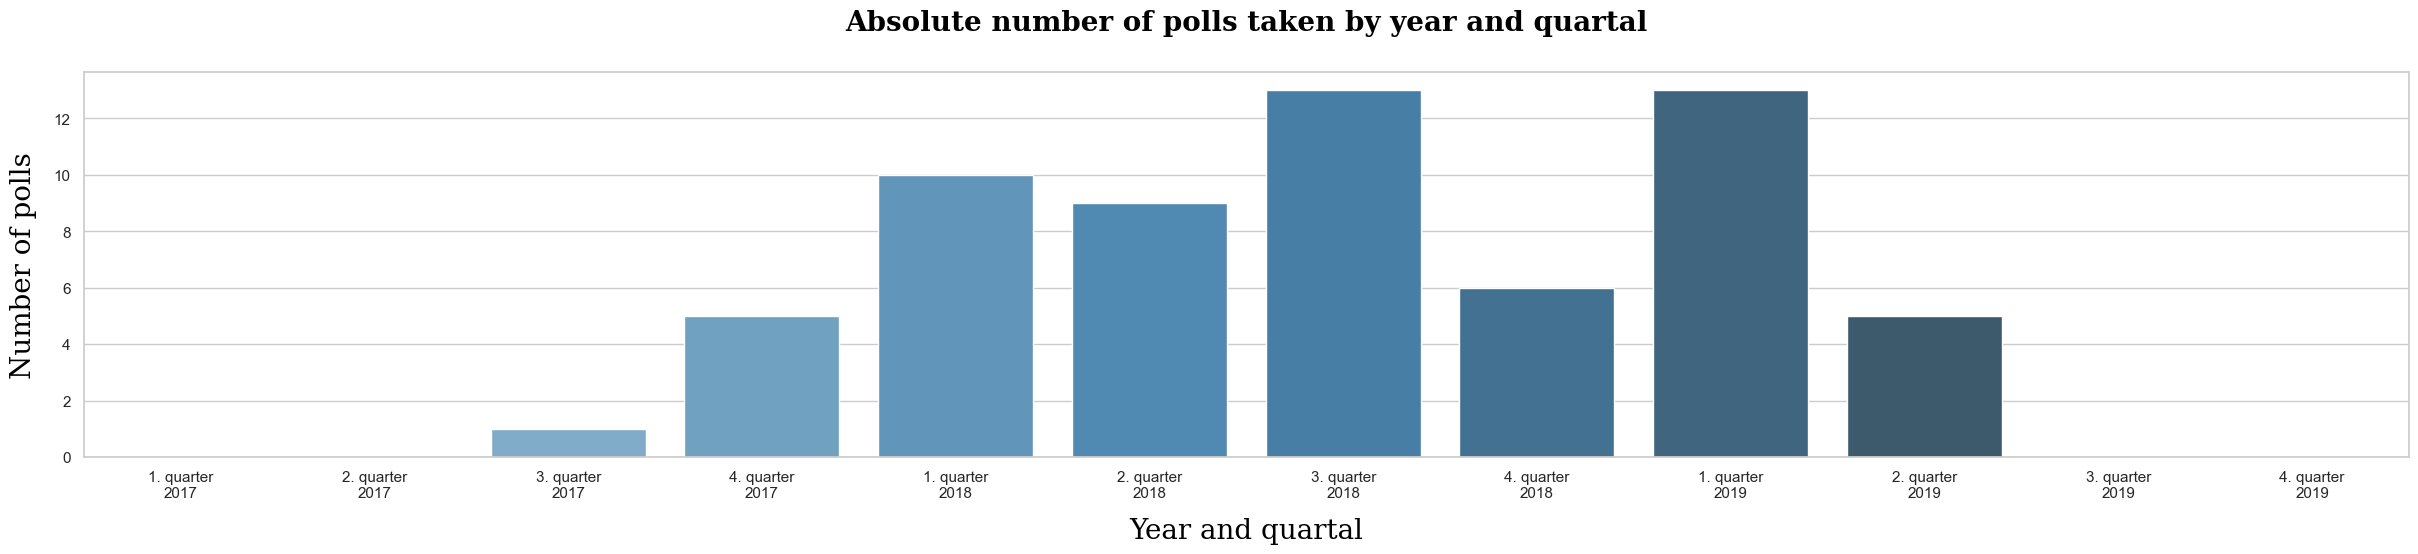

In [73]:
'''Reshape axis labels specifically for barplot'''
labels_year_quarter = []                                                # declare list for labels

for j in range (0, len(labels_year)):                                   # loop through years
    for i in range (0, len(labels_quarter)):                            # loop through quartals
        helpString = str(labels_quarter[i])+'\n'+str(labels_year[j])    # create string for label -> String is structured like this: '1. quarter\n2017' because the labels are too long and would overlap
        labels_year_quarter.append(helpString)                          # append string to list

'''SQL Querys to get the data for the barplot'''

cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2017 GROUP BY startQuartal")  # Count every survey in 2017 where Start and End Date are equal and the quarter is equal
data_2017 = cursor.fetchall()                                                                                                                                                               # fetch query result -> returns a list of tuples                               


cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2018 GROUP BY startQuartal")  # Count every survey in 2018 where Start and End Date are equal and the quarter is equal
data_2018 = cursor.fetchall()                                                                                                                                                               # see above

cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2019 GROUP BY startQuartal")  # Count every survey in 2019 where Start and End Date are equal and the quarter is equal
data_2019 = cursor.fetchall()                                                                                                                                                               # see above

'''Data Preparation'''

data_2017 = dataYearQuartal(data_2017)  # get count for each quartal
data_2018 = dataYearQuartal(data_2018)  # see above
data_2019 = dataYearQuartal(data_2019)  # see above

barCharArray = []                       # declare list for dataframe
barCharArray.extend(data_2017)          # extend list with data from 2017
barCharArray.extend(data_2018)          # extend list with data from 2018
barCharArray.extend(data_2019)          # extend list with data from 2019

df_bar = pd.DataFrame(data=[barCharArray], index=['count'], columns=labels_year_quarter)  # create dataframe for barplot

'''Plotting'''

fig, ax = plt.subplots(figsize=(30,5))                                                                                                                          # create figure and axis      
ax = sns.barplot(data=df_bar, palette="Blues_d")                                                                                                                # create barplot with seaborn       
ax.set_xlabel('Year and quartal', fontsize=20, fontfamily='serif', color='black', labelpad=12)                                                                  # set x label
ax.set_ylabel('Number of polls', fontsize=20, fontfamily='serif', color='black', labelpad=12)                                                                   # set y label
ax.set_title('Absolute number of polls taken by year and quartal', fontsize=20, pad=30, fontfamily='serif', fontweight='bold', color='black', loc='center')     # set title of plot

fig.savefig('images\\BARCHART_absolute_number_polls_year_quartal.png', dpi=300, bbox_inches='tight')                                                            # save figure as png in images folder


## Dashboard

Due to the task formulated task says, that the axes should be represented within one figure. For this reason a kind of dashboard was created. The dashboard just contains all previvous axes but within one figure.

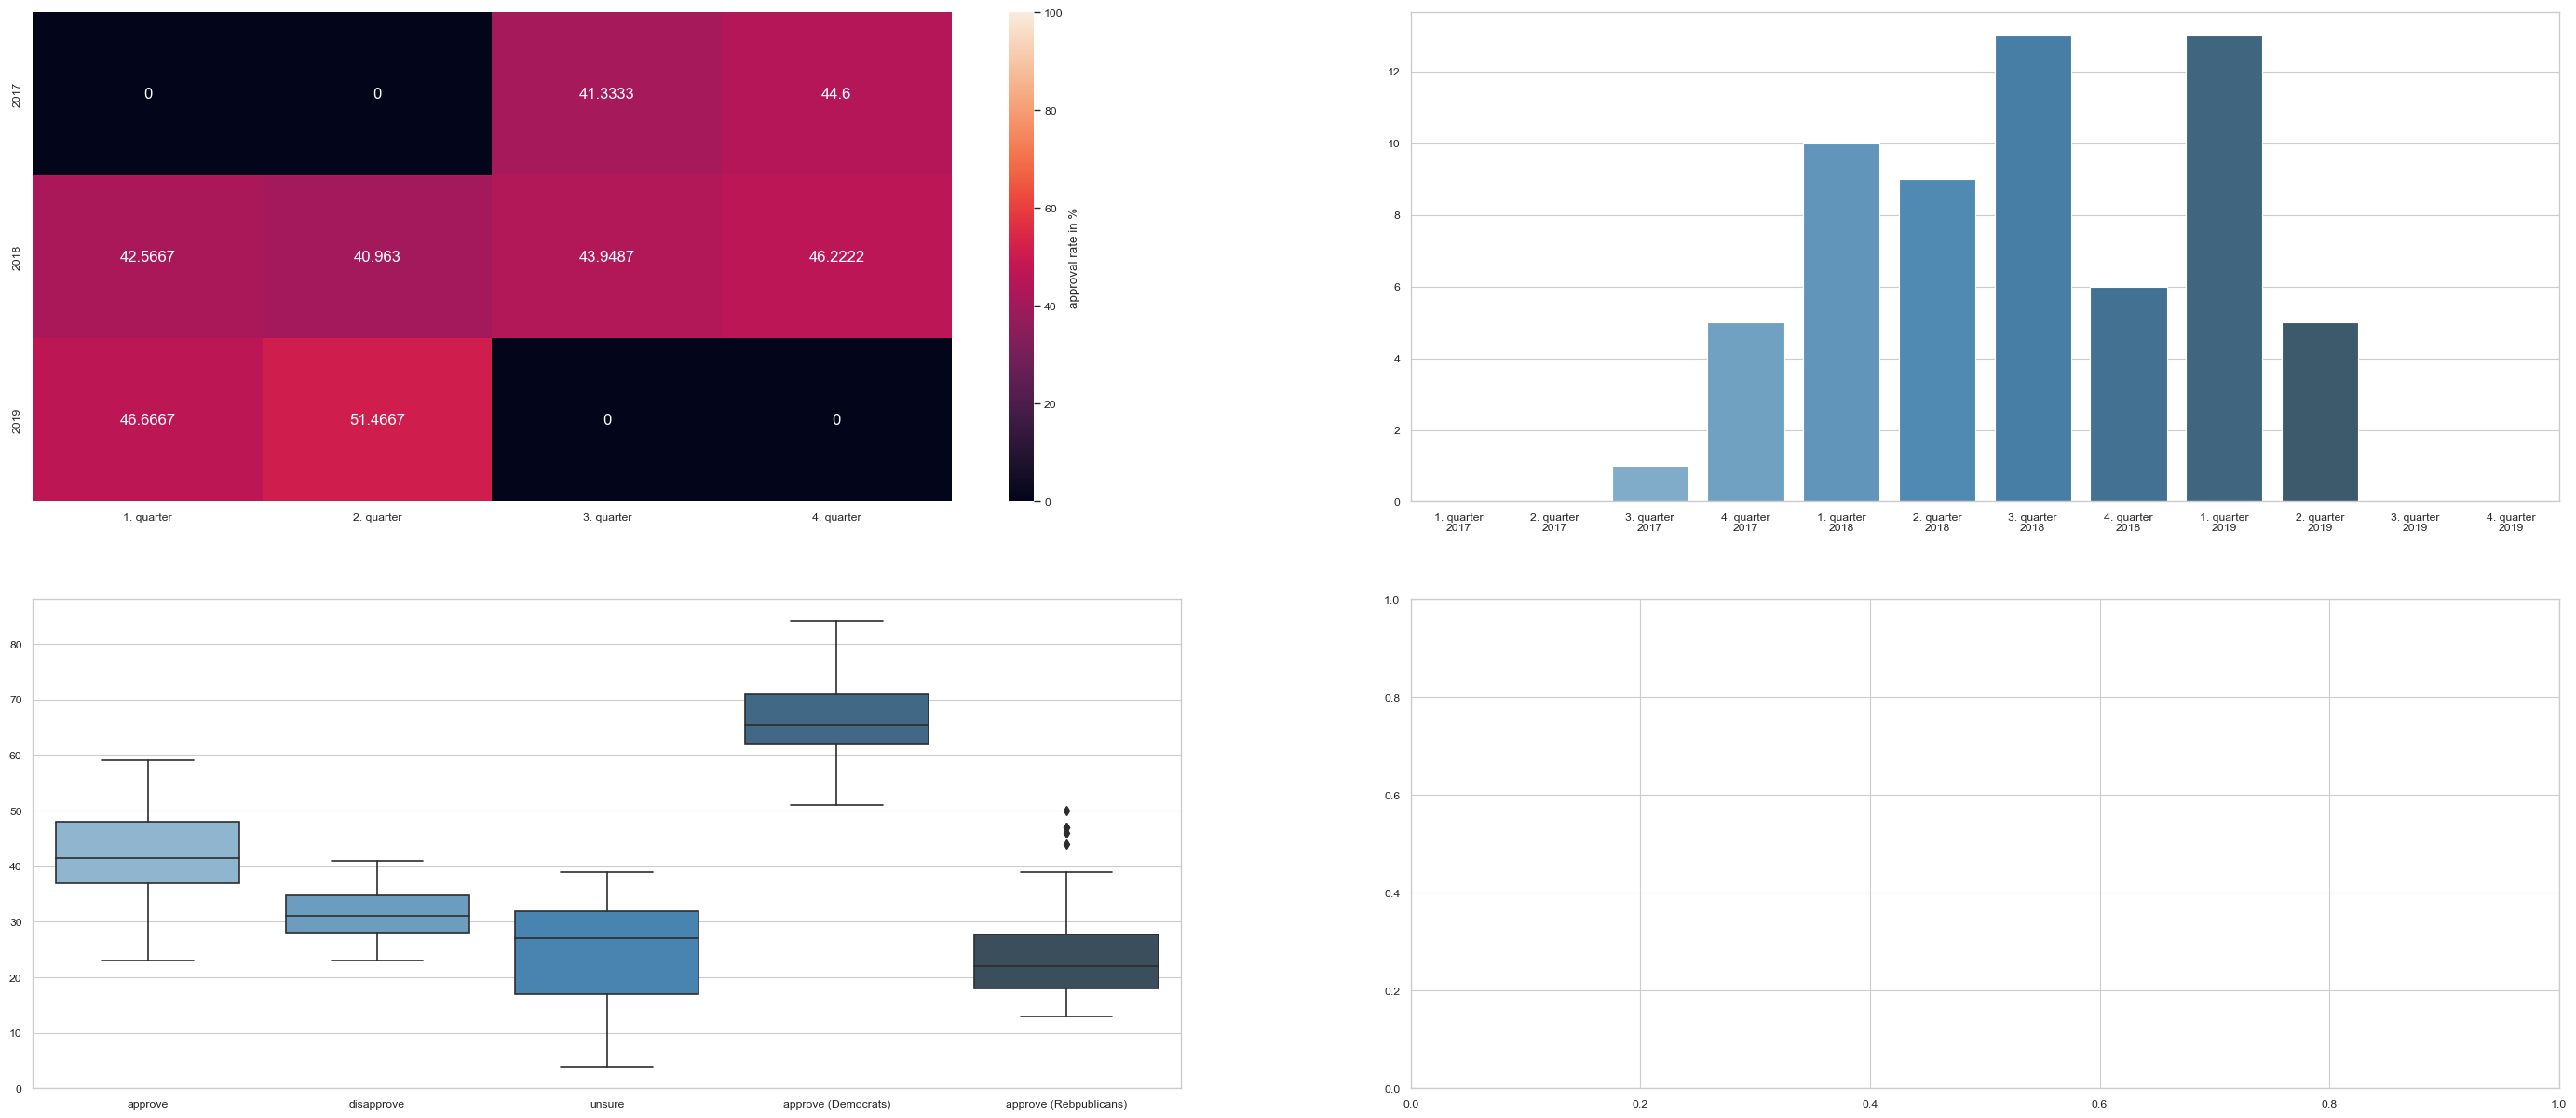

In [91]:
f, axes = plt.subplots(2, 2, figsize=(35, 15))                                                                                                              # create figure and multiple axis
sns.set(style="whitegrid")                                                                                                                                  # set style of plot
sns.set_context("paper")                                                                                                                                    # set context of plot

fig1 = sns.heatmap(df_heat, annot=True, fmt="g", vmin=0, vmax=100, annot_kws={"size": 12}, cbar_kws={'label': 'approval rate in %'}, ax=axes[0, 0])         # create heatmap with seaborn

fig2 = sns.barplot(data=df_bar, palette="Blues_d", ax = axes[0, 1])                                                                                         # create barplot with seaborn
fig3 = sns.boxplot(data=df_data_without, palette="Blues_d", ax = axes[1, 0])                                                                                # create boxplot with seaborn

f.savefig('images\\ALL.png', dpi=300, bbox_inches='tight')                                                                                                  # save figure as png in images folder